# Оптсание поректа

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## План выполнения исследования

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.iolib.table import SimpleTable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

Загрузим датасет в переменную `data`

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Изучим есть ли в данных пропуски

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

Пропусков нет, ресемплируем данные по 1 часу.

In [6]:
data.sort_index(ascending=True, inplace=True)
data = data.resample('1H').sum()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [9]:
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

### Промежуточный вывод

1. В данных отсутствуют пропуски;
2. Данные в таблице представлены за промежуток с 1 марта по 31 августа 2018го года;
3. Данные были ресемплированы по 1 часу.

## Анализ данных

Представим данные графически за различные промежутки времени

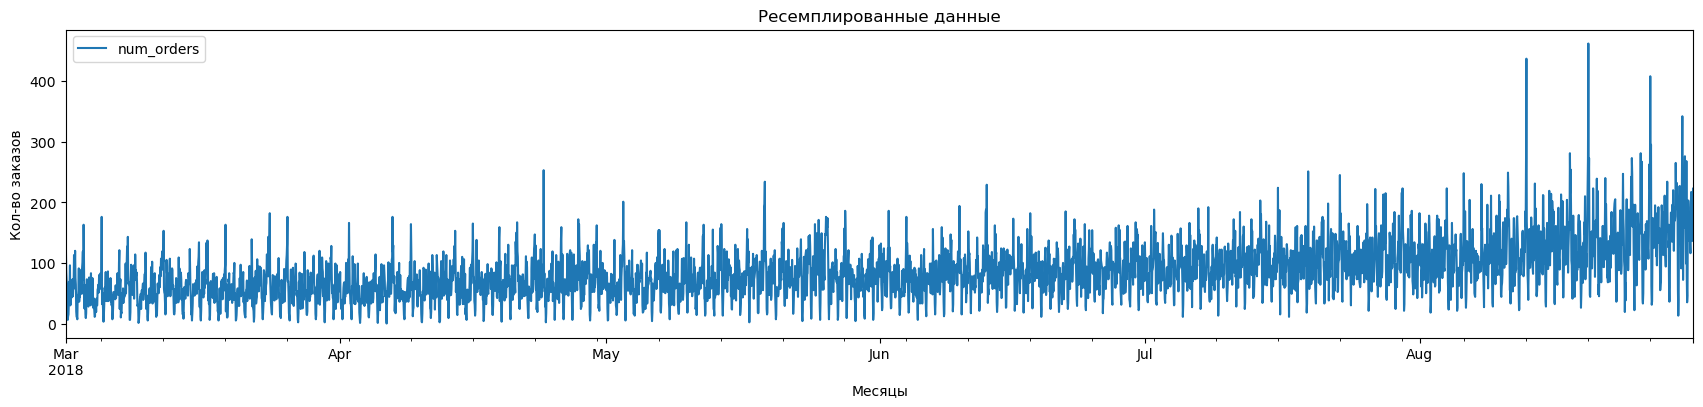

In [10]:
figsize = (21,4)
data.plot(figsize=figsize)
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

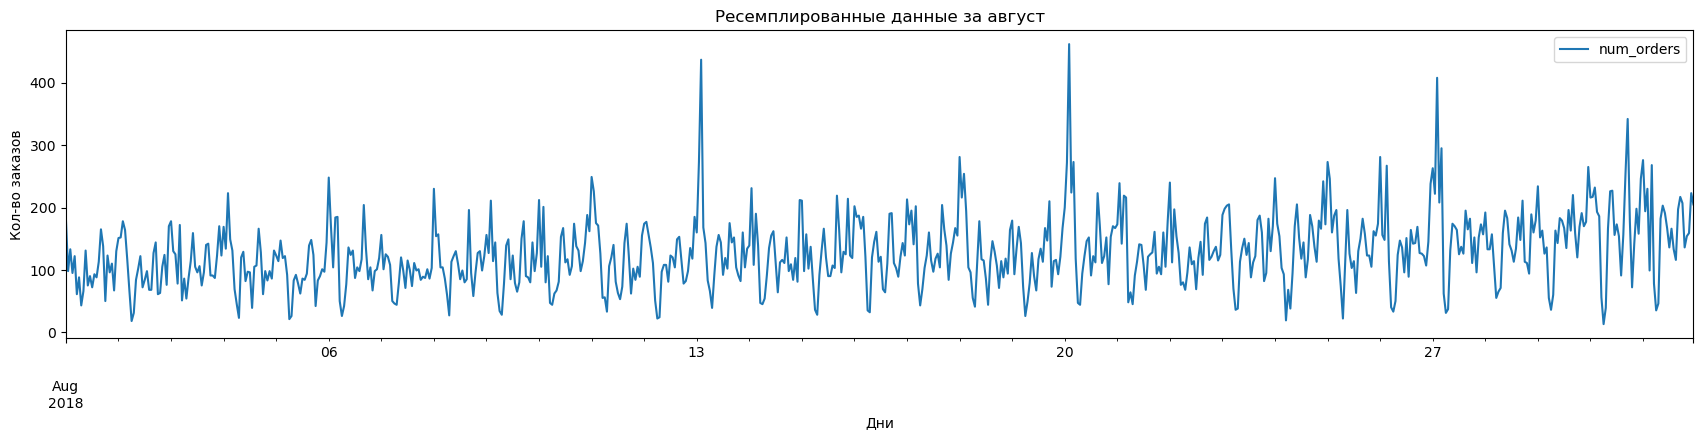

In [11]:
data['2018-08-01':].plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

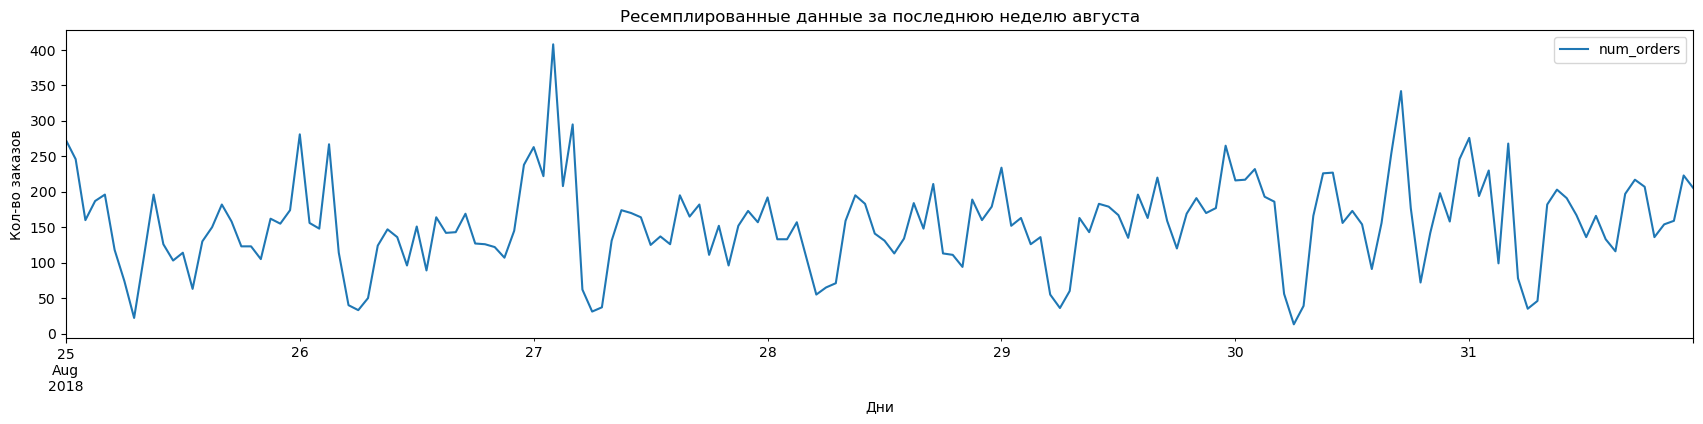

In [12]:
data['2018-08-25':].plot(figsize=figsize)
plt.title('Ресемплированные данные за последнюю неделю августа')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

### Промежуточный вывод

1. По данным можно заметить, что за весь промежуток времени в целом количество заказов возрастает;
2. В августе наблюдаются резкие скачки в заказах по понедельникам;
3. В течение дня заметно, что количество заказов возрастает ко второй половине дня и спадает после полуночи.

## Скользящие среднее и стандартное распределение

Исследуем аналогичным образом скользящие среднее и стандартное распределение.

In [13]:
data['std'] = data['num_orders'].rolling(7).std()
data['mean'] = data['num_orders'].rolling(7).mean()

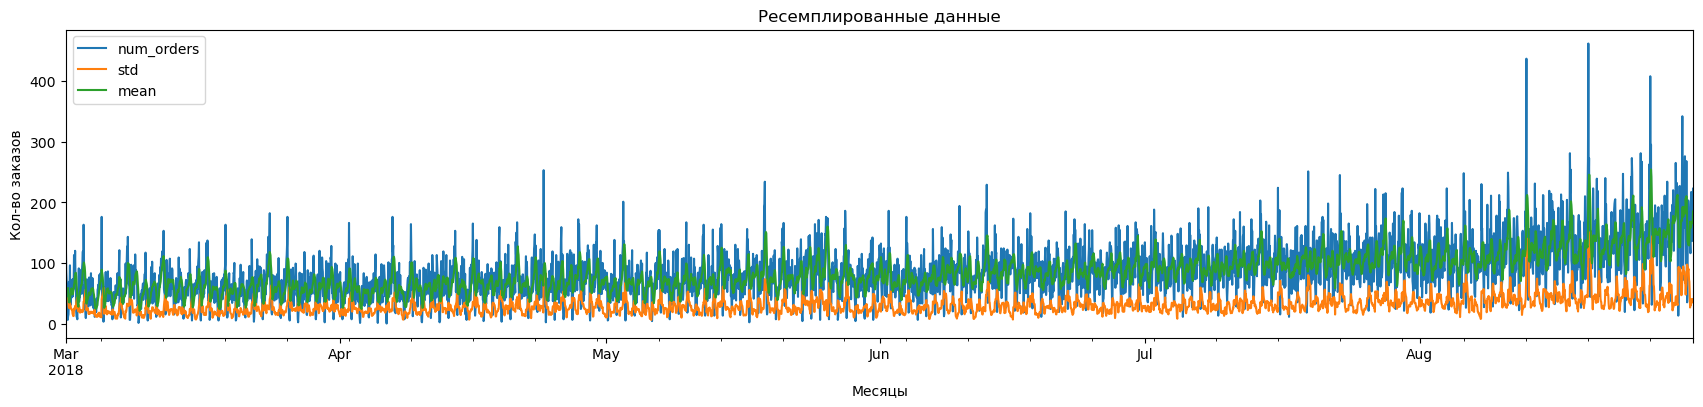

In [14]:
data.plot(figsize=figsize)
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

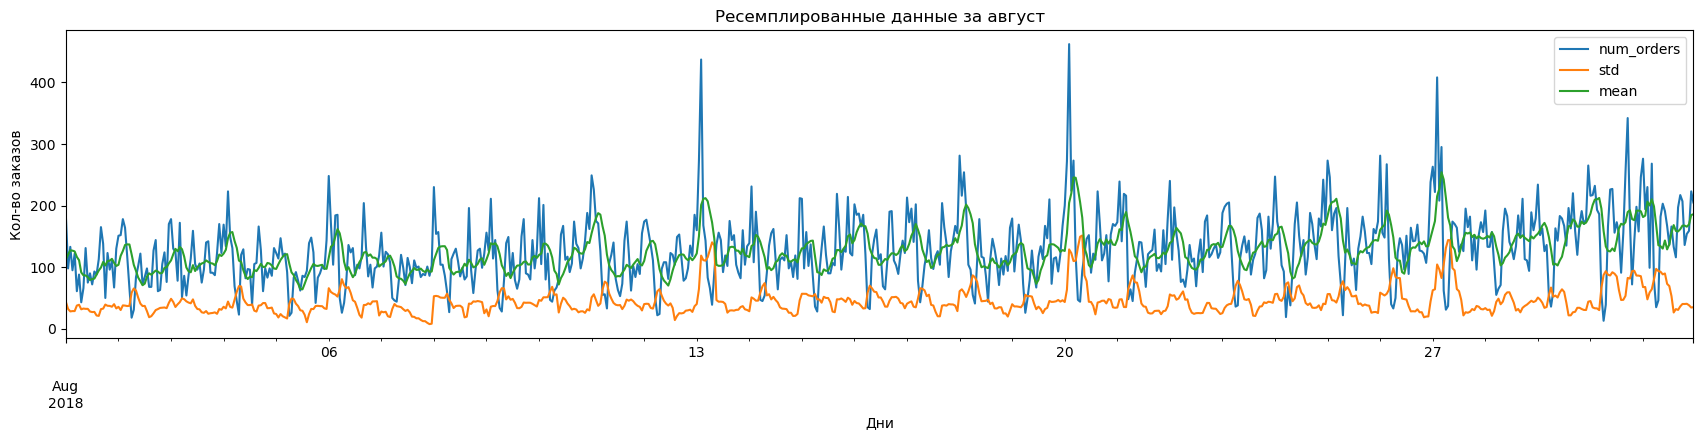

In [15]:
data['2018-08-01':].plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

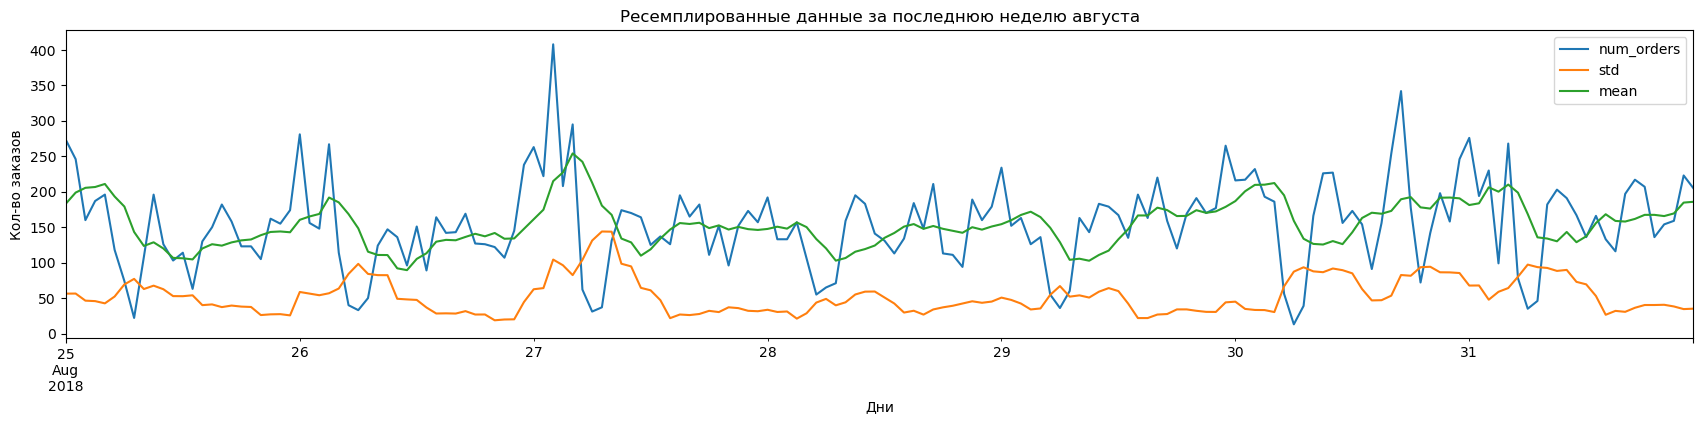

In [16]:
data['2018-08-25':].plot(figsize=figsize)
plt.title('Ресемплированные данные за последнюю неделю августа')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

Проверим ряд на стационарность при помощи теста Дики-Фуллера

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
test = sm.tsa.adfuller(data['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf:  -3.0689242890279567
p-value:  0.02894005140261284
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Единичных корней нет, ряд стационарен


### Промежуточный вывод

Графически представили распределение скользящих среднего и стандартного отклонения, а также при помощи теста Дики-Фуллера проверили ряд на стационарность. В результате теста можем сделать вывод о том, что гипотеза о том, что ряд стационарный не может быть отвергнута.

### Декомпозиция

Проведём декомпозицию временного ряда.

In [19]:
decomposed = seasonal_decompose(data['num_orders'])

**Тренд**

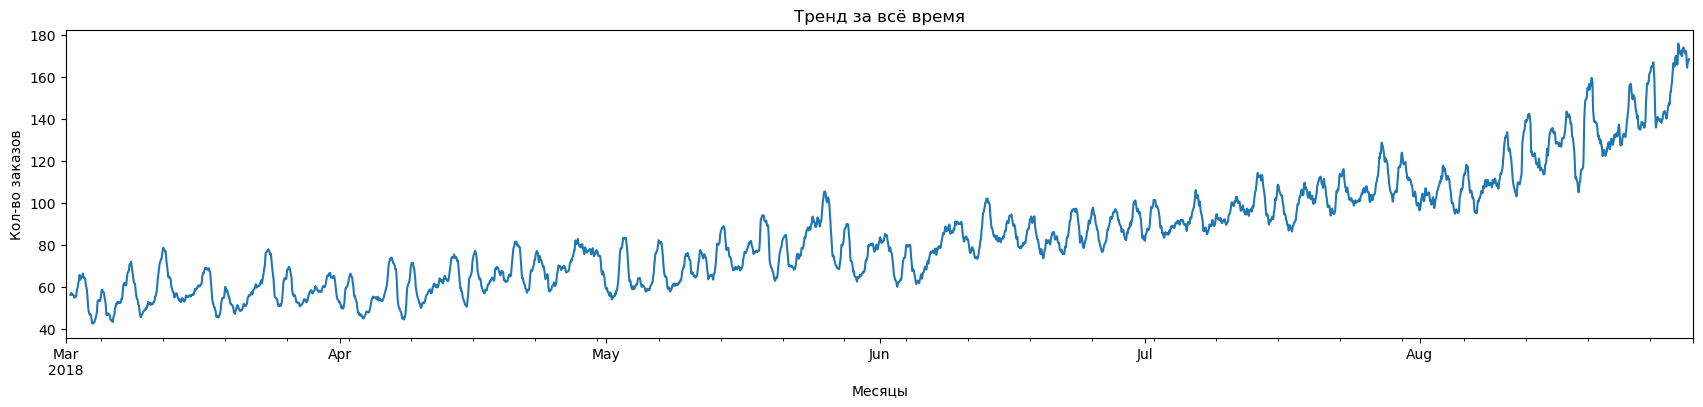

In [20]:
decomposed.trend.plot(figsize=figsize)
plt.title('Тренд за всё время')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

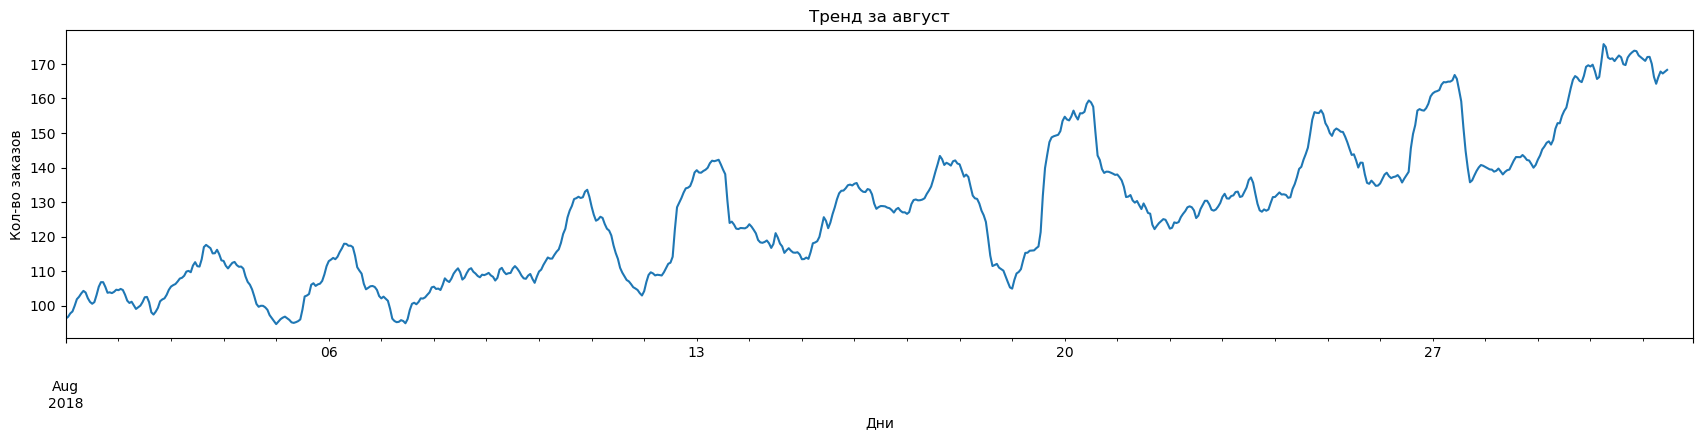

In [21]:
decomposed.trend['2018-08-01':].plot(figsize=figsize)
plt.title('Тренд за август')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

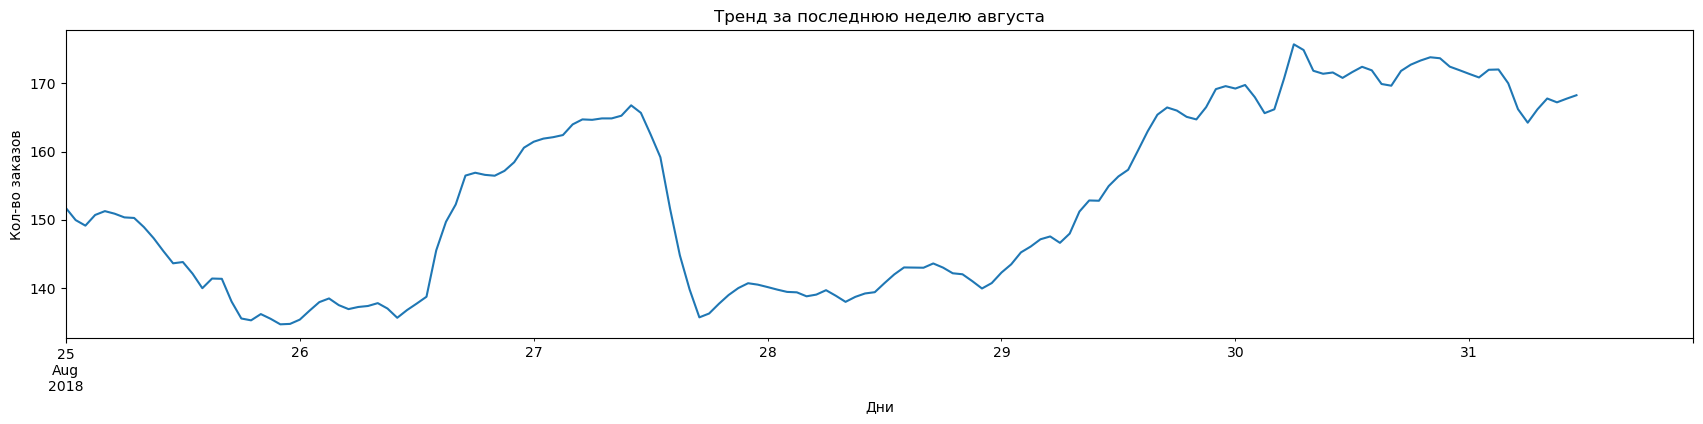

In [22]:
decomposed.trend['2018-08-25':].plot(figsize=figsize)
plt.title('Тренд за последнюю неделю августа')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

**Сезонность**

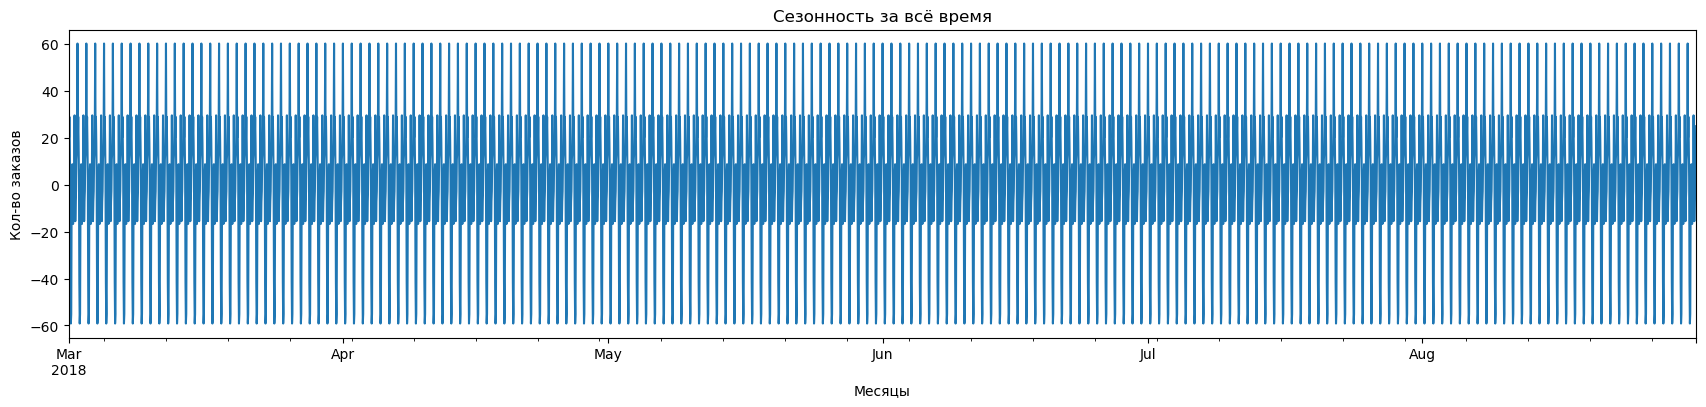

In [23]:
decomposed.seasonal.plot(figsize=figsize)
plt.title('Сезонность за всё время')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

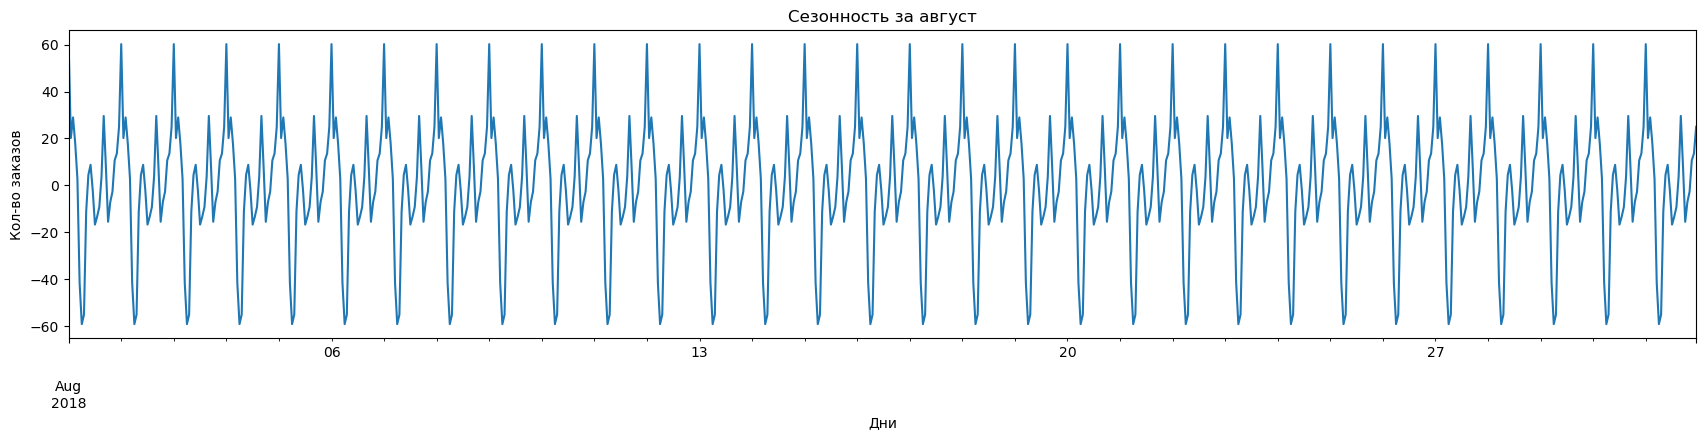

In [24]:
decomposed.seasonal['2018-08-01':].plot(figsize=figsize)
plt.title('Сезонность за август')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

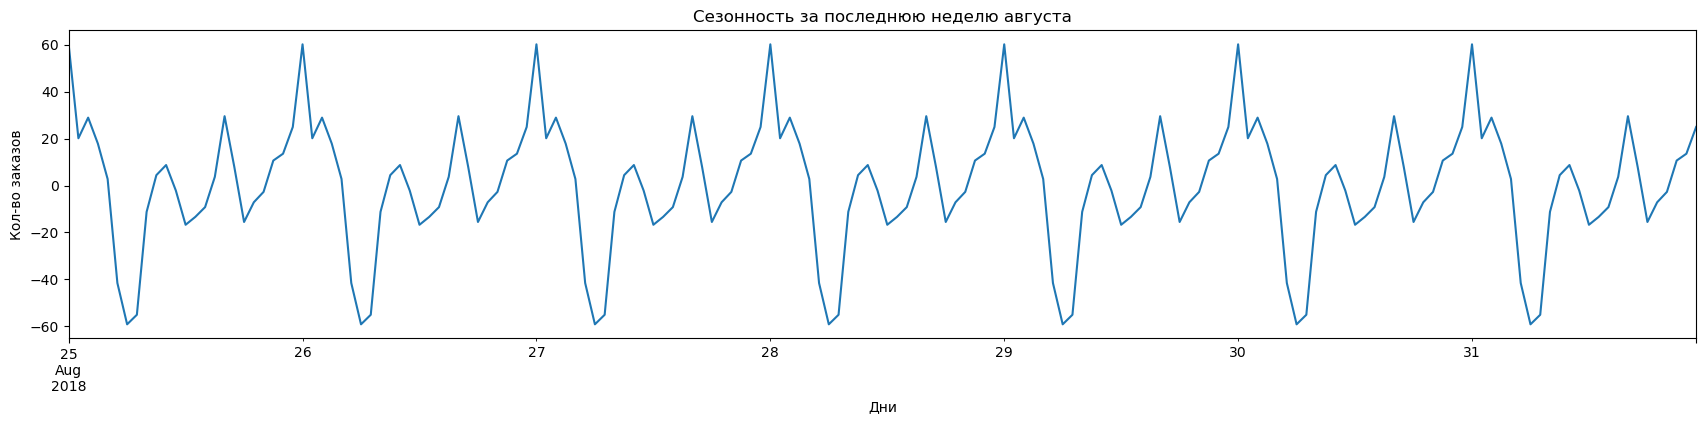

In [25]:
decomposed.seasonal['2018-08-25':].plot(figsize=figsize)
plt.title('Сезонность за последнюю неделю августа')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

**Остатки**

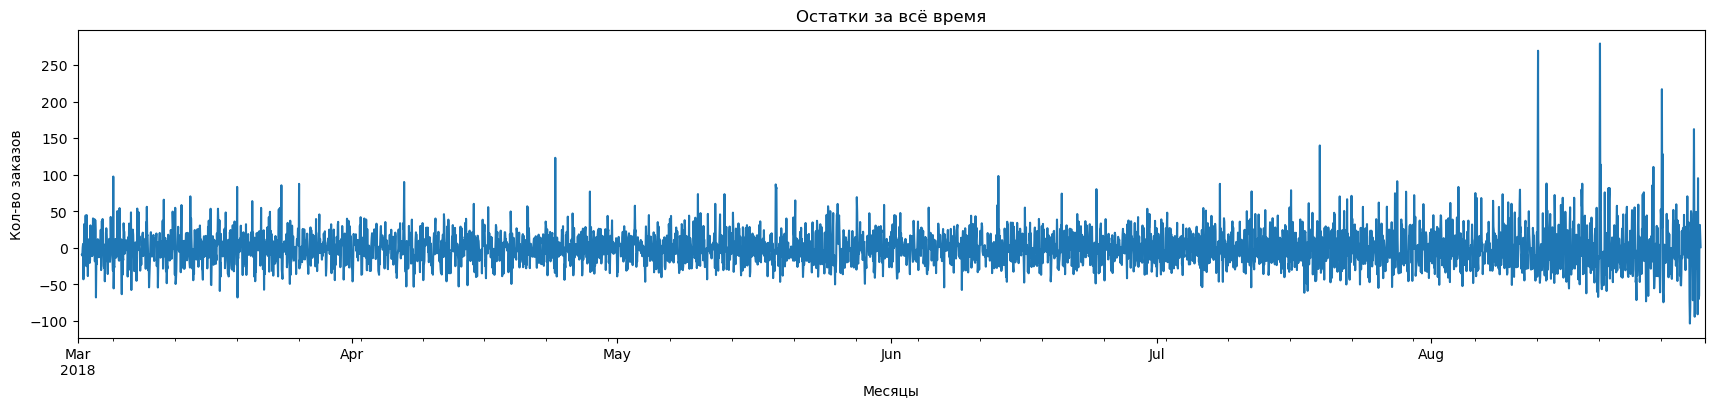

In [26]:
decomposed.resid.plot(figsize=figsize)
plt.title('Остатки за всё время')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

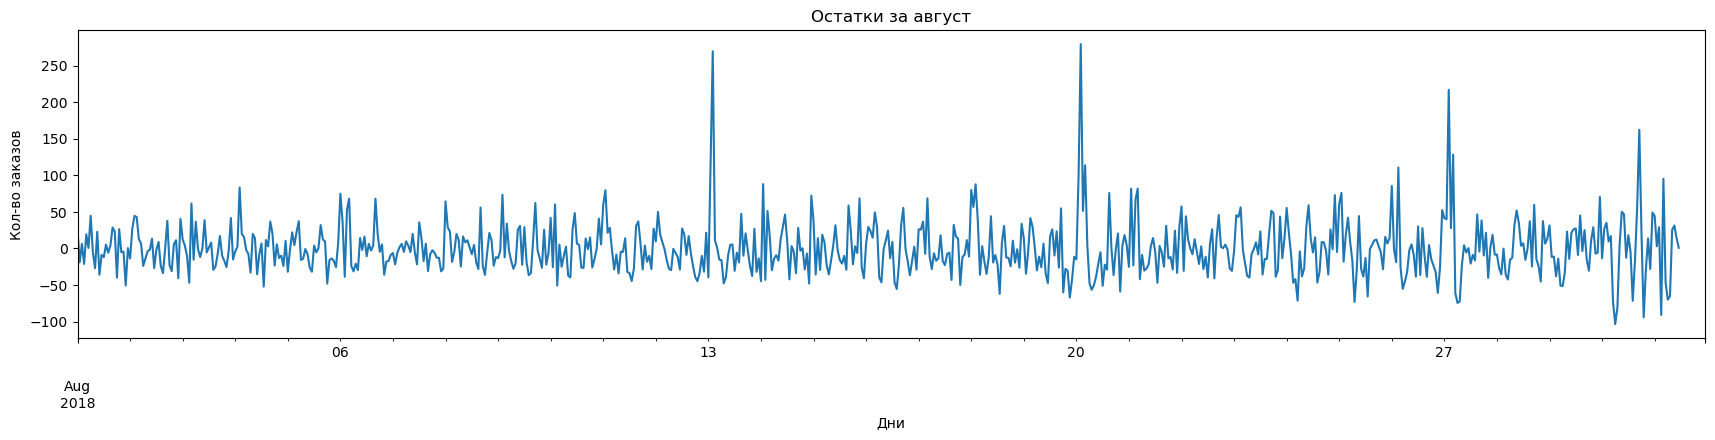

In [27]:
decomposed.resid['2018-08-01':].plot(figsize=figsize)
plt.title('Остатки за август')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

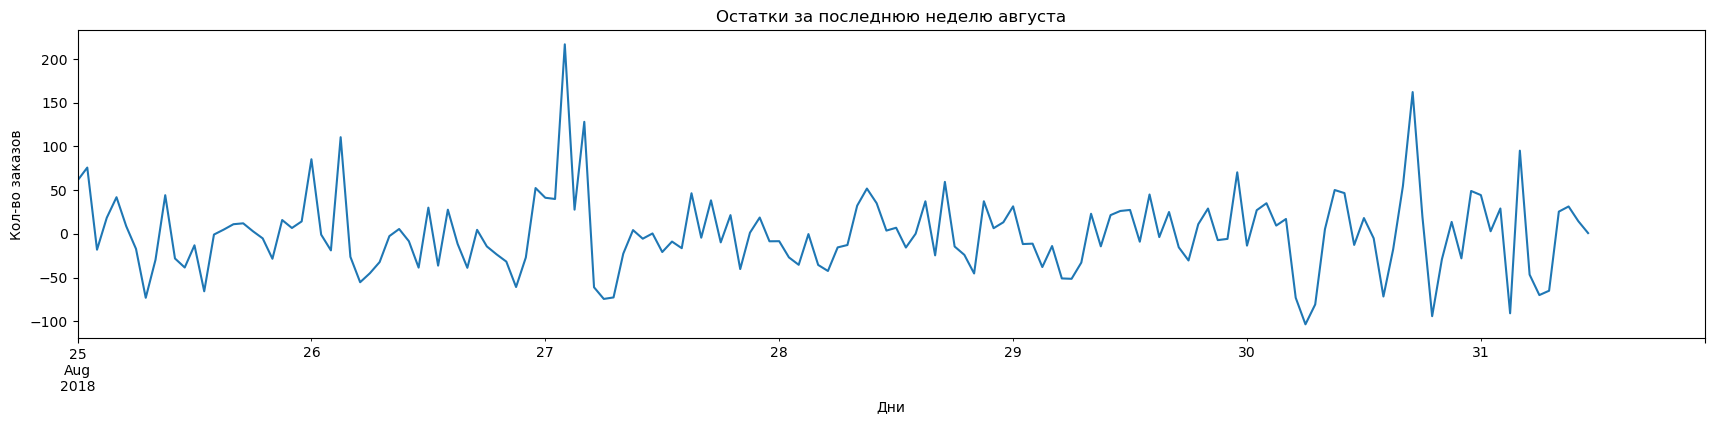

In [28]:
decomposed.resid['2018-08-25':].plot(figsize=figsize)
plt.title('Остатки за последнюю неделю августа')
plt.xlabel('Дни')
plt.ylabel('Кол-во заказов')
plt.show()

### Промежуточный вывод

1. Заметно явное возрастание тренда, которое постепенно уисиливается ос времнем, хотя и остаётся при этом практически линейным;
2. Заметна крайне явная суточная сезонность. Абсолютный пик заказов приходится на полночь, ему предшествует меньший пик около 12 часов дня, минимум же заказов приходится на утренние часы;
3. По графикам можно сказать, что день недели имеет значение, в связи с чем это придётся учесть на обучении моделей.

## Обучение и тестирование моделей

In [29]:
data.drop(columns=['std', 'mean'], inplace=True)

Обучим 3 модели: `LinearRegression`, `RandomForestRegressor`, `LGBMRegressor`.

Перед этим данные разобьём на обучающую, тестовую и валидационную выборки в соотношении 8:1:1. Добавим данные о дате/времени в отдельные колонки.

In [30]:
def make_features(data, max_lag, rolling_mean_size):
    data_model = data.copy()
    data_model['dayofweek'] = data_model.index.dayofweek
    data_model['hour'] = data_model.index.hour
    data_model['day'] = data_model.index.day
    data_model['month'] = data_model.index.month
    
    for lag in range(1, max_lag + 1):
        data_model['lag_{}'.format(lag)] = data_model['num_orders'].shift(lag)

    data_model['rolling_mean'] = data_model['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_model

### Линейная регрессия

In [31]:
%%time
best_rmse = 48

for max_lag in range(1, 100):
    for rolling_mean_size in range(1, 100):
        data_model = make_features(data, max_lag, rolling_mean_size)
        data_model = data_model.dropna()
        train, valid = train_test_split(data_model, shuffle=False, test_size=.2, random_state=12345)
        valid, test = train_test_split(valid, shuffle=False, test_size=.5, random_state=12345)
        
        features_train = train.drop('num_orders', axis=1)
        target_train = train.num_orders
        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid.num_orders
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        rmse = mean_squared_error(target_valid, predictions, squared=False)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
            
print('лучшее RMSE =', best_rmse, 'при лаге', best_max_lag, ', окне', best_rolling_mean_size)
rmse_valid_lr = best_rmse

лучшее RMSE = 30.189899453741596 при лаге 96 , окне 99
Wall time: 4min 33s


Протестируем модель на лучших параметрах.

In [32]:
data_model = make_features(data, best_max_lag, best_rolling_mean_size)
data_model.dropna(inplace=True)

train, valid = train_test_split(data_model, shuffle=False, test_size=.2, random_state=12345)

valid, test = train_test_split(valid, shuffle=False, test_size=.5, random_state=12345)

features_train = train.drop('num_orders', axis=1)
target_train = train.num_orders

features_test = test.drop('num_orders', axis=1)
target_test = test.num_orders

model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
        
rmse = mean_squared_error(target_test, predictions, squared=False)
rmse_test_lr = rmse
print('RMSE линейной регресии на тестовой выборке =', rmse)

RMSE линейной регресии на тестовой выборке = 43.50950325697479


Визуализируем предсказания на тестовой выборке:

In [33]:
predictions_lr = pd.DataFrame(predictions, index = target_test.index)

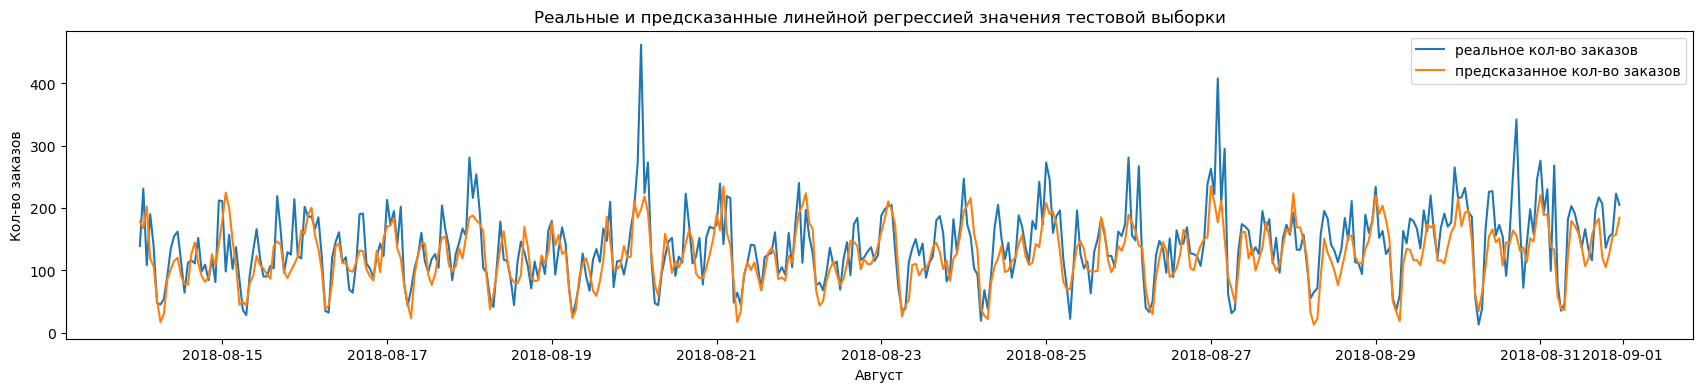

In [34]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, predictions_lr, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные линейной регрессией значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

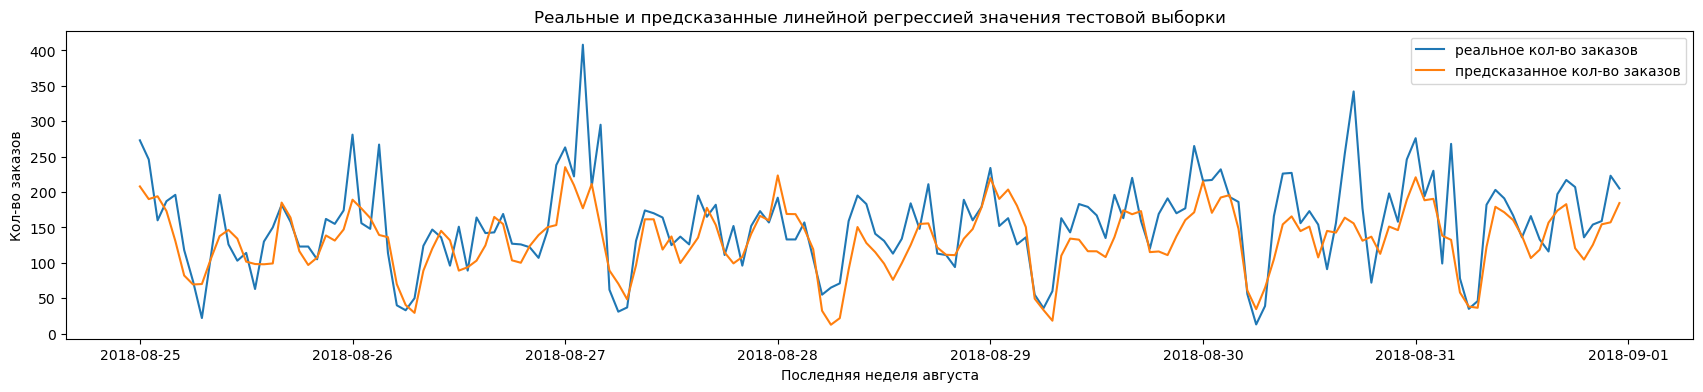

In [35]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test['2018-08-25':].index, target_test['2018-08-25':], label='реальное кол-во заказов')
ax.plot(target_test['2018-08-25':].index, predictions_lr['2018-08-25':], label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные линейной регрессией значения тестовой выборки')
plt.xlabel('Последняя неделя августа')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

#### Промежуточный вывод

На графиках видно, что линейная регрессия относительно точно справляется с предсказаниями, "повторяет форму" в большинстве случаев, но плохо справляется с положительными выбросами.

### Случайный лес

In [36]:
%%time
best_rmse = 48

for max_lag in range(1, 101, 5):
    for rolling_mean_size in range(1, 101, 5):
        for max_depth in range(2, 21):
            data_model = make_features(data, max_lag, rolling_mean_size)

            train, valid = train_test_split(data_model, shuffle=False, test_size=.2)
            train = train.dropna()

            valid, test = train_test_split(valid, shuffle=False, test_size=.1)

            features_train = train.drop('num_orders', axis=1)
            target_train = train.num_orders

            features_valid = valid.drop('num_orders', axis=1)
            target_valid = valid.num_orders

    
            model = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
        
            rmse = mean_squared_error(target_valid, predictions, squared=False)
        
            if rmse < best_rmse:
                best_rmse = rmse
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
                best_max_depth = max_depth
            
print('RMSE дерева решений =', best_rmse, 'при лаге', best_max_lag, 'окне', best_rolling_mean_size, 'глубине', best_max_depth)
rmse_valid_rf = best_rmse

RMSE дерева решений = 41.08127427972442 при лаге 51 окне 6 глубине 7
Wall time: 22min 56s


Протестируем модель на лучших параметрах

In [37]:
data_model = make_features(data, best_max_lag, best_rolling_mean_size)
data_model.dropna(inplace=True)

train, valid = train_test_split(data_model, shuffle=False, test_size=.2, random_state=12345)

valid, test = train_test_split(valid, shuffle=False, test_size=.5, random_state=12345)

features_train = train.drop('num_orders', axis=1)
target_train = train.num_orders

features_test = test.drop('num_orders', axis=1)
target_test = test.num_orders

model = DecisionTreeRegressor(max_depth=best_max_depth, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
        
rmse = mean_squared_error(target_test, predictions, squared=False)
rmse_test_rf = rmse
print('RMSE дерева решений на тестовой выборке =', rmse)

RMSE дерева решений на тестовой выборке = 50.322885623638584


In [38]:
predictions_rf = pd.DataFrame(predictions, index = target_test.index)

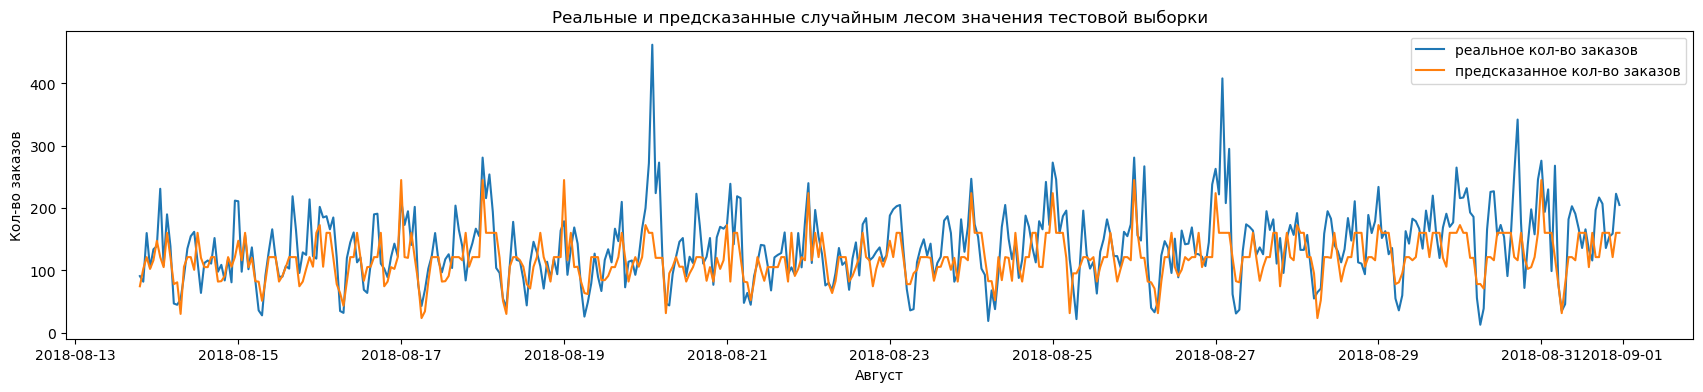

In [39]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, predictions_rf, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные случайным лесом значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

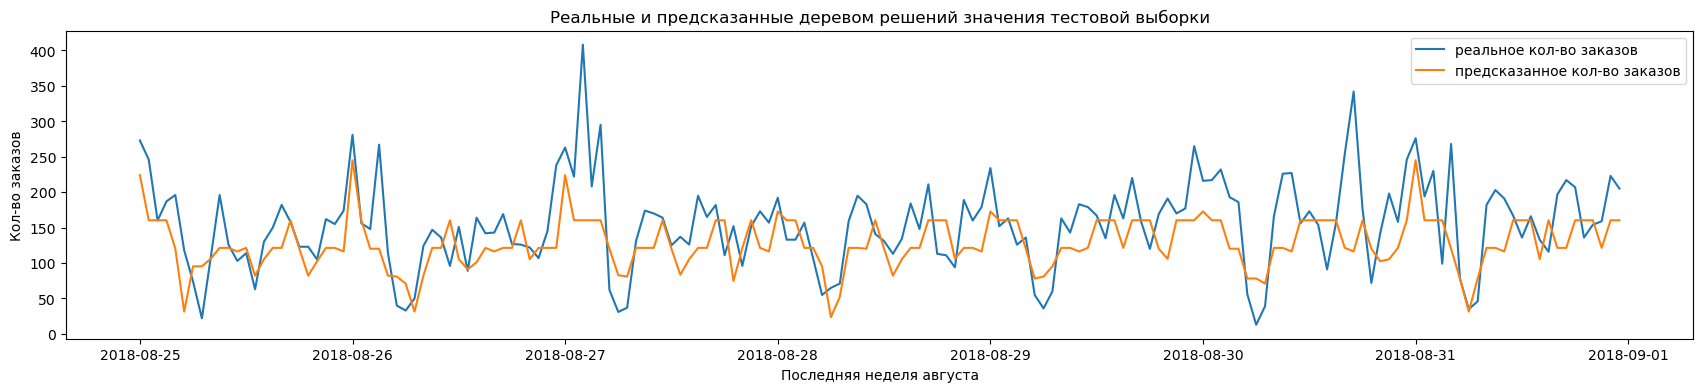

In [40]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test['2018-08-25':].index, target_test['2018-08-25':], label='реальное кол-во заказов')
ax.plot(target_test['2018-08-25':].index, predictions_rf['2018-08-25':], label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные деревом решений значения тестовой выборки')
plt.xlabel('Последняя неделя августа')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

#### Промежуточный вывод

На графиках видно, что дерево решений справляется с предсказаниями хуже линейной регрессии, также это потверждается метрикой.

### LGBMRegressor

In [41]:
model = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rmse = (max(mts) * -1) ** .5
rmse_valid_lgb = rmse
print('RMSE LightGBMRegressor на тренировочной выборке =',rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9146
[LightGBM] [Info] Number of data points in the train set: 2793, number of used features: 56
[LightGBM] [Info] Start training from score 78.904046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9019
[LightGBM] [Info] Number of data points in the train set: 2793, number of used features: 56
[LightGBM] [Info] Start training from score 77.208378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8956
[LightGBM] [Info] Number of data points in the train set: 2794, number of used features: 56
[LightGBM] [Info] Start trai

In [42]:
model = LGBMRegressor(learning_rate=.1, num_leaves=25, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
rmse_test_lgb = rmse
print('RMSE LightGBMRegressor на тестовой выборке =', rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9298
[LightGBM] [Info] Number of data points in the train set: 3492, number of used features: 56
[LightGBM] [Info] Start training from score 74.522623
RMSE LightGBMRegressor на тестовой выборке = 47.46831598504986


In [43]:
predictions_lgb = pd.DataFrame(predictions, index = target_test.index)

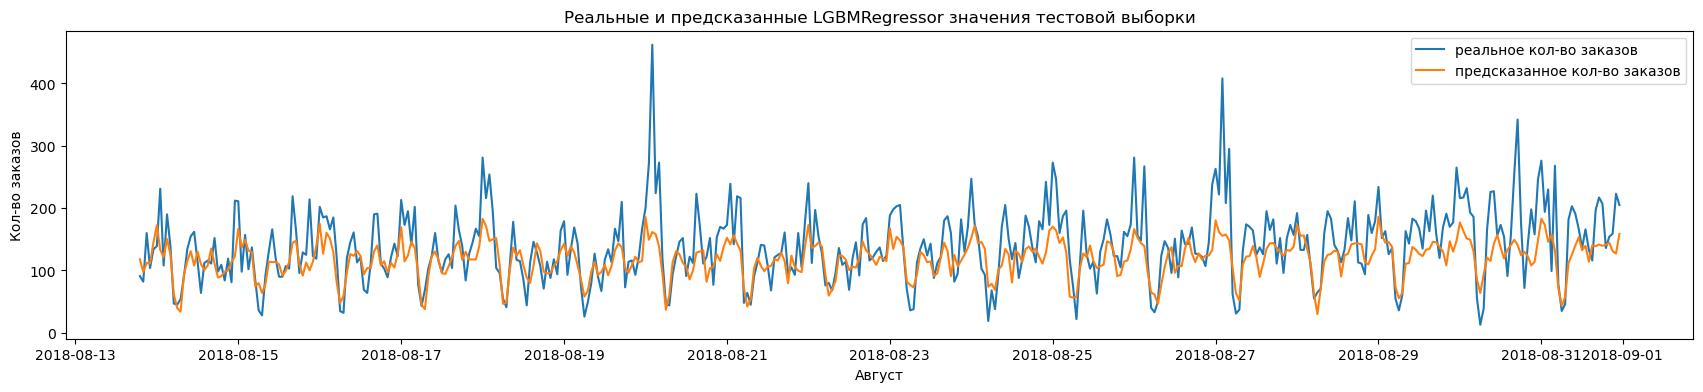

In [44]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, predictions_lgb, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные LGBMRegressor значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

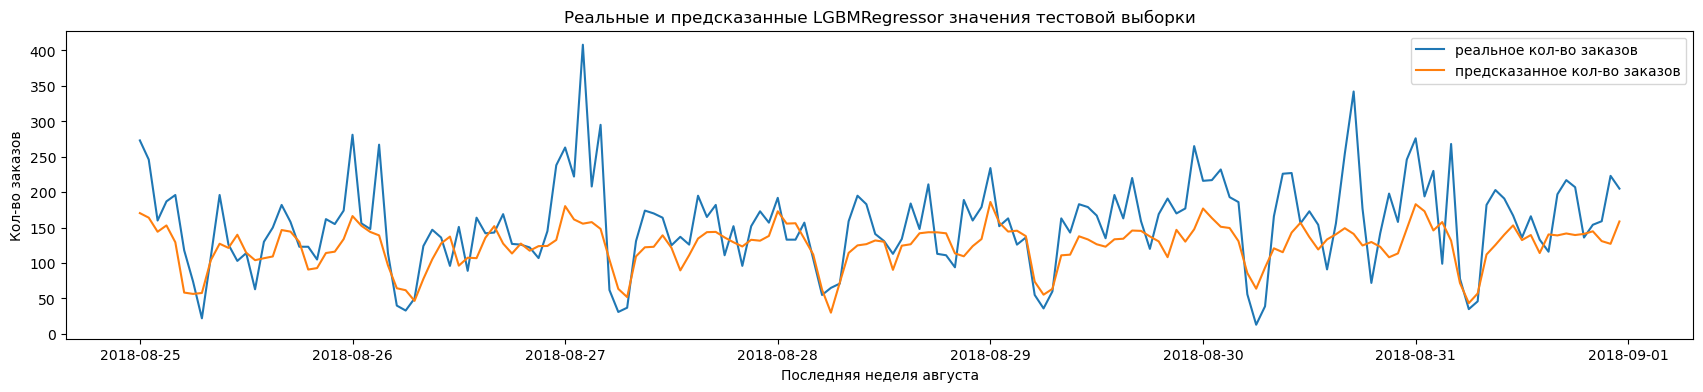

In [45]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test['2018-08-25':].index, target_test['2018-08-25':], label='реальное кол-во заказов')
ax.plot(target_test['2018-08-25':].index, predictions_lgb['2018-08-25':], label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные LGBMRegressor значения тестовой выборки')
plt.xlabel('Последняя неделя августа')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

#### Промежуточный вывод

По графику и метрике $RMSE$ видно, что модель `LGBMRegressor` предсказывает достаточно недостаточно точно.

### Промежуточный вывод

Соберём полученные метрики в сводную таблицу

In [46]:
table_fin = pd.DataFrame(columns=['RMSE валидация', 'RMSE тест'], index=['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor'])
table_fin['RMSE валидация'] = [rmse_valid_lr, rmse_valid_rf, rmse_valid_lgb]
table_fin['RMSE тест'] = [rmse_test_lr, rmse_test_rf, rmse_test_lgb]
table_fin.style.highlight_min(color='yellowgreen',subset=['RMSE валидация', 'RMSE тест']).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=['RMSE валидация', 'RMSE тест'])

,RMSE валидация,RMSE тест
LinearRegression,30.189899,43.509503
RandomForestRegressor,41.081274,50.322886
LGBMRegressor,21.811959,47.468316


По результатам проведённого исследования можем сказать следующее:
1. Линейная регрессия показывает лучший результат на валидационной выборке;
2. Случайный лес показывает худшие результаты как на валидационной, так и на тестовой выборке и является единственной моделью, которая не смогла достичь планки в $RMSE < 48$ среди 3 моделей;
3. `LGBMRegressor` показывает лучший результат на валидационной выборке, но при этом хуже показывает себя на тестовой выборке.

## Вывод

В результате проведённого исследования были достигнуты следующие цели:
1. Были загружены данные и ресемплированы по одному часу.
2. Данные были проанализированы
3. Были обучены 3 разные модели с различными гиперпараметрами, которые были проверены на тестовой выборке в размере 10% от изначальных данных.

В резульатете обучения и проверки моделей на тестовой выборке компании «Чётенькое такси» можно порекомендовать использовать для прогнозирования количества заказов на следующий час модель линейной регрессии, так как эта модель показала наилучшую точность предсказания, что и является главным критерием.